# Model 2: Multi-Layer Perceptron (MLP) Neural Network
## Automobile Price Prediction - Improved Implementation

**CS3AM Coursework - Deep Learning Component**

This notebook implements a carefully designed MLP neural network for automobile price prediction. The architecture and hyperparameters are specifically optimised for small dataset performance, following deep learning best practices.

---

### Key Design Decisions

| Decision | Rationale | Reference |
|----------|-----------|------------|
| Target scaling | Stabilises gradient descent with large target values | Goodfellow et al. (2016) |
| Shallow architecture | Prevents overfitting with limited training samples | Hastie et al. (2009) |
| Cross-validated tuning | Robust hyperparameter selection | Bergstra & Bengio (2012) |
| Aggressive regularisation | Mitigates overfitting on small datasets | Srivastava et al. (2014) |

## 1. Environment Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Evaluation
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    explained_variance_score, median_absolute_error, max_error
)
from scipy import stats

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ==============================================================================
# SET RANDOM SEEDS FOR REPRODUCIBILITY
# ==============================================================================
# Without fixed seeds, neural network results vary between runs due to:
# - Random weight initialisation (Glorot & Bengio, 2010)
# - Stochastic gradient descent batch sampling
# - Dropout mask randomness
# ==============================================================================

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configure visualisation settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'figure.figsize': (12, 6)
})

print("TensorFlow version:", tf.__version__)
print("Random seed set to:", SEED)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.19.0
Random seed set to: 42
GPU Available: False


## 2. Data Loading and Initial Exploration

In [ ]:
# Load dataset with proper missing value handling
df = pd.read_csv('Automobile_data.csv', na_values='?')

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Original shape: {df.shape[0]} samples, {df.shape[1]} features")

# Remove rows with missing target variables
df = df[df['price'].notna()]
print(f"After removing missing prices: {df.shape[0]} samples")

# Display the missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print(f"\nMissing values in {len(missing)} columns:")
    print(missing)
    print(f"Total missing values: {missing.sum()}")

DATASET OVERVIEW
Original shape: 205 samples, 26 features
After removing missing prices: 201 samples

Missing values in 6 columns:
normalized-losses    37
num-of-doors          2
bore                  4
stroke                4
horsepower            2
peak-rpm              2
dtype: int64
Total missing values: 51


In [ ]:
# Separate features and target
y = df['price'].astype(np.float32).values
X = df.drop('price', axis=1)

# Identify the column types for preprocessing
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64', 'float32']).columns.tolist()

print("\n" + "="*70)
print("FEATURE ANALYSIS")
print("="*70)
print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
print(f"\nTarget variable statistics:")
print(f"  Min: ${y.min():,.0f}")
print(f"  Max: ${y.max():,.0f}")
print(f"  Mean: ${y.mean():,.0f}")
print(f"  Std: ${y.std():,.0f}")


FEATURE ANALYSIS
Numeric features: 15
Categorical features: 10

Target variable statistics:
  Min: $5,118
  Max: $45,400
  Mean: $13,207
  Std: $7,927


## 3. Data Preprocessing

Neural networks require careful preprocessing:

1. **Numeric features**: Impute missing values with median (robust to outliers), then standardise to zero mean and unit variance. Standardisation is essential for gradient-based optimisation (LeCun et al., 2012).

2. **Categorical features**: Impute with the mode, then with one-hot encode. Neural networks cannot process categorical strings directly.

3. **Target variable**: Scale to similar range as features. This is **critical** for stable training with MSE loss.

In [ ]:
# Numeric preprocessing: median imputation + standardisation
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: mode imputation + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine them into the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# ==============================================================================
# CRITICAL: TARGET VARIABLE SCALER
# ==============================================================================
# Neural networks with MSE loss struggle when target values are large.
# Price ranges from $5,000 to $45,000. Without scaling:
#   - Gradients are proportional to (error)^2
#   - A $10,000 error produces gradient ~100,000,000
#   - This causes unstable training and slow convergence
#
# Solution: Scale target to approximately N(0,1) during training,
# then inverse transform predictions for evaluation.
# ==============================================================================

y_scaler = StandardScaler()

print("Preprocessing pipeline created.")
print("Target scaler created (StandardScaler).")

Preprocessing pipeline created.
Target scaler created (StandardScaler).


In [ ]:
# Using identical split to Model 1 (Random Forest) for fair comparison.
# random_state=42 ensures reproducibility across both models.

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Apply feature preprocessing
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# APPLY TARGET SCALING
# fit_transform on training data only to prevent data leakage
# transform (not fit_transform) on test data

y_train_scaled = y_scaler.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test_raw.reshape(-1, 1)).flatten()

# Store original (unscaled) test values for final evaluation
y_test = y_test_raw

print("\n" + "="*70)
print("TRAIN/TEST SPLIT")
print("="*70)
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Features after preprocessing: {X_train.shape[1]}")
print(f"\nTarget scaling applied:")
print(f"  Original range: ${y_train_raw.min():,.0f} to ${y_train_raw.max():,.0f}")
print(f"  Scaled range: {y_train_scaled.min():.2f} to {y_train_scaled.max():.2f}")
print(f"  Scaled mean: {y_train_scaled.mean():.4f} (should be ~0)")
print(f"  Scaled std: {y_train_scaled.std():.4f} (should be ~1)")


TRAIN/TEST SPLIT
Training samples: 160
Testing samples: 41
Features after preprocessing: 74

Target scaling applied:
  Original range: $5,118 to $45,400
  Scaled range: -1.10 to 4.86
  Scaled mean: 0.0000 (should be ~0)
  Scaled std: 1.0000 (should be ~1)


## 4. Model Architecture Design

### 4.1 Architecture Rationale

The architecture is designed specifically for **small dataset performance**. Key considerations:

| Principle | Application | Justification |
|-----------|-------------|---------------|
| **Parsimony** | 2 hidden layers, 32→16 neurons | With 160 training samples, complex architectures overfit. Hastie et al. (2009) recommend models with fewer parameters than training samples. |
| **Regularisation** | L2 weight decay + Dropout | Dual regularisation reduces effective model capacity (Srivastava et al., 2014). |
| **Batch Normalisation** | After each dense layer | Stabilises training, allows higher learning rates, provides mild regularisation (Ioffe & Szegedy, 2015). |
| **Activation** | ReLU hidden, Linear output | ReLU avoids vanishing gradients (Nair & Hinton, 2010). Linear output is standard for regression. |

### 4.2 Capacity Analysis

For a dataset of 160 training samples, the recommended parameter count is:
- **Maximum**: 160 × 10 = 1,600 parameters (rule of thumb: ≥10 samples per parameter)
- **Conservative**: 160 × 5 = 800 parameters

Our architecture achieves approximately **2,700 parameters**, which is higher than ideal but mitigated by strong regularisation.

In [ ]:
def create_mlp_model(input_dim,
                     hidden_units=[32, 16],
                     dropout_rate=0.3,
                     l2_reg=0.01,
                     learning_rate=0.001):
    """
    Create an MLP model optimised for small datasets.

    Architecture Design Decisions:
    ------------------------------
    1. Shallow network (2 hidden layers) - prevents overfitting on 160 samples
    2. Batch normalisation - stabilises training, mild regularisation effect
    3. L2 regularisation - penalises large weights, reduces overfitting
    4. Dropout - randomly disables neurons, forces redundant representations
    5. Adam optimiser - adaptive learning rates per parameter (Kingma & Ba, 2015)

    Parameters:
    -----------
    input_dim : int
        Number of input features after preprocessing
    hidden_units : list
        Neurons per hidden layer (default: [32, 16])
    dropout_rate : float
        Fraction of neurons to drop (default: 0.3)
    l2_reg : float
        L2 regularisation strength (default: 0.01)
    learning_rate : float
        Adam optimiser learning rate (default: 0.001)

    Returns:
    --------
    Compiled Keras model
    """

    model = keras.Sequential(name='MLP_Regressor')

    # Input layer
    model.add(layers.Input(shape=(input_dim,), name='input'))

    # Hidden layers
    for i, units in enumerate(hidden_units):
        model.add(layers.Dense(
            units,
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg),
            name=f'dense_{i+1}'
        ))
        model.add(layers.BatchNormalization(name=f'bn_{i+1}'))
        model.add(layers.Dropout(dropout_rate, name=f'dropout_{i+1}'))

    # Output layer (linear activation for regression)
    model.add(layers.Dense(1, activation='linear', name='output'))

    # Compile with Adam optimiser
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    return model

# Create initial model to display the architecture
input_dim = X_train.shape[1]
model = create_mlp_model(input_dim)

print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
model.summary()

# Calculate and display the parameter analysis
total_params = model.count_params()
samples_per_param = X_train.shape[0] / total_params

print("\n" + "="*70)
print("CAPACITY ANALYSIS")
print("="*70)
print(f"Total parameters: {total_params:,}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Samples per parameter: {samples_per_param:.3f}")
print(f"Recommended minimum: 0.10 (10 samples per parameter)")
if samples_per_param < 0.1:
    print(f"\nWARNING: Model may overfit. Regularisation is essential.")
else:
    print(f"\nCapacity is appropriate for dataset size.")


MODEL ARCHITECTURE


Model: "MLP_Regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,041 (11.88 KB)

 Non-trainable params: 96 (384.00 B)


CAPACITY ANALYSIS
Total parameters: 3,137
Training samples: 160
Samples per parameter: 0.051
Recommended minimum: 0.10 (10 samples per parameter)



## 5. Hyperparameter Tuning with Cross-Validation

To ensure robust hyperparameter selection, we use **5-fold cross-validation**. This prevents overfitting to the validation set and provides uncertainty estimates for each configuration.

### Search Space

| Hyperparameter | Values | Rationale |
|----------------|--------|----------|
| Hidden layers | [32,16], [64,32], [32,16,8] | Test shallow vs slightly deeper |
| Dropout rate | 0.2, 0.3, 0.4 | Higher dropout for smaller datasets |
| L2 regularisation | 0.001, 0.01, 0.1 | Range from light to strong |
| Learning rate | 0.01, 0.001, 0.0001 | Standard range for Adam |

In [ ]:
# Define the search space
param_grid = {
    'hidden_units': [[32, 16], [64, 32], [32, 16, 8], [16, 8]],
    'dropout_rate': [0.2, 0.3, 0.4],
    'l2_reg': [0.001, 0.01, 0.1],
    'learning_rate': [0.01, 0.001, 0.0001]
}

# Calculate total combinations
total_combinations = 1
for key in param_grid:
    total_combinations *= len(param_grid[key])

print("="*70)
print("HYPERPARAMETER SEARCH SPACE")
print("="*70)
for key, values in param_grid.items():
    print(f"  {key}: {values}")
print(f"\nTotal combinations: {total_combinations}")
print(f"With 5-fold CV: {total_combinations * 5} model fits")
print("\nNote: Full grid search would be slow. Using randomised search with 20 samples.")

HYPERPARAMETER SEARCH SPACE
  hidden_units: [[32, 16], [64, 32], [32, 16, 8], [16, 8]]
  dropout_rate: [0.2, 0.3, 0.4]
  l2_reg: [0.001, 0.01, 0.1]
  learning_rate: [0.01, 0.001, 0.0001]

Total combinations: 108
With 5-fold CV: 540 model fits

Note: Full grid search would be slow. Using randomised search with 20 samples.


In [ ]:
# RANDOMISED SEARCH WITH 5-FOLD CROSS-VALIDATION

from itertools import product
import random

# Generate all combinations and sample randomly
all_combinations = list(product(
    param_grid['hidden_units'],
    param_grid['dropout_rate'],
    param_grid['l2_reg'],
    param_grid['learning_rate']
))

# Sample 20 combinations for efficiency
random.seed(SEED)
sampled_combinations = random.sample(all_combinations, min(20, len(all_combinations)))

print(f"\nEvaluating {len(sampled_combinations)} hyperparameter combinations...")
print("This will take 2-5 minutes.\n")

# Cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
results = []

for idx, (hidden, dropout, l2, lr) in enumerate(sampled_combinations):
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        # Split data
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train_scaled[train_idx], y_train_scaled[val_idx]

        # Create and train model (silent)
        model = create_mlp_model(
            input_dim=X_train.shape[1],
            hidden_units=hidden,
            dropout_rate=dropout,
            l2_reg=l2,
            learning_rate=lr
        )

        # Early stopping for CV
        es = EarlyStopping(
            monitor='val_loss',
            patience=15,
            mode='min',
            restore_best_weights=True,
            verbose=0
        )

        # Train
        model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=16,
            callbacks=[es],
            verbose=0
        )

        # Evaluate (in scaled space)
        y_pred_scaled = model.predict(X_val, verbose=0).flatten()

        # Convert back to original scale for meaningful MAE
        y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        y_val_original = y_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

        mae = mean_absolute_error(y_val_original, y_pred)
        fold_scores.append(mae)

        # Clean up
        keras.backend.clear_session()

    # Store results
    mean_mae = np.mean(fold_scores)
    std_mae = np.std(fold_scores)
    results.append({
        'hidden_units': hidden,
        'dropout_rate': dropout,
        'l2_reg': l2,
        'learning_rate': lr,
        'mean_mae': mean_mae,
        'std_mae': std_mae
    })

    print(f"Config {idx+1}/{len(sampled_combinations)}: "
          f"hidden={hidden}, dropout={dropout}, l2={l2}, lr={lr} "
          f"-> MAE: ${mean_mae:,.0f} (+/- ${std_mae:,.0f})")

print("\nHyperparameter search complete.")


Evaluating 20 hyperparameter combinations...
This will take 2-5 minutes.



Config 1/20: hidden=[16, 8], dropout=0.2, l2=0.001, lr=0.01 -> MAE: $1,584 (+/- $291)


Config 2/20: hidden=[32, 16], dropout=0.3, l2=0.01, lr=0.0001 -> MAE: $3,311 (+/- $847)
Config 3/20: hidden=[32, 16], dropout=0.2, l2=0.01, lr=0.01 -> MAE: $1,558 (+/- $215)
Config 4/20: hidden=[16, 8], dropout=0.3, l2=0.01, lr=0.001 -> MAE: $2,296 (+/- $244)
Config 5/20: hidden=[64, 32], dropout=0.2, l2=0.1, lr=0.0001 -> MAE: $3,853 (+/- $419)
Config 6/20: hidden=[64, 32], dropout=0.2, l2=0.01, lr=0.001 -> MAE: $1,989 (+/- $260)
Config 7/20: hidden=[64, 32], dropout=0.2, l2=0.001, lr=0.001 -> MAE: $2,026 (+/- $292)
Config 8/20: hidden=[32, 16], dropout=0.3, l2=0.1, lr=0.0001 -> MAE: $4,042 (+/- $1,125)
Config 9/20: hidden=[32, 16], dropout=0.3, l2=0.01, lr=0.001 -> MAE: $2,121 (+/- $99)
Config 10/20: hidden=[16, 8], dropout=0.2, l2=0.01, lr=0.0001 -> MAE: $4,079 (+/- $426)
Config 11/20: hidden=[32, 16, 8], dropout=0.3, l2=0.1, lr=0.01 -> MAE: $1,909 (+/- $343)
Config 12/20: hidden=[32, 16], dropout=0.3, l2=0.001, lr=0.0001 -> MAE: $3,943 (+/- $691)
Config 13/20: hidden=[32, 16, 8], dr

In [ ]:
# SELECT BEST HYPERPARAMETERS

# Sort by mean MAE (lower is better)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('mean_mae')

print("\n" + "="*70)
print("TOP 5 HYPERPARAMETER CONFIGURATIONS")
print("="*70)
print(results_df.head(10).to_string(index=False))

# Select the best configuration
best_config = results_df.iloc[0]

print("\n" + "="*70)
print("BEST HYPERPARAMETERS SELECTED")
print("="*70)
print(f"  Hidden units: {best_config['hidden_units']}")
print(f"  Dropout rate: {best_config['dropout_rate']}")
print(f"  L2 regularisation: {best_config['l2_reg']}")
print(f"  Learning rate: {best_config['learning_rate']}")
print(f"\n  5-Fold CV MAE: ${best_config['mean_mae']:,.2f} (+/- ${best_config['std_mae']:,.2f})")


TOP 5 HYPERPARAMETER CONFIGURATIONS
hidden_units  dropout_rate  l2_reg  learning_rate    mean_mae    std_mae
    [32, 16]           0.2   0.010          0.010 1558.332275 214.681308
     [16, 8]           0.2   0.001          0.010 1584.144946 290.750252
    [64, 32]           0.2   0.001          0.010 1625.976001 290.734120
 [32, 16, 8]           0.2   0.001          0.010 1678.468066 270.726768
 [32, 16, 8]           0.3   0.100          0.010 1908.566284 343.264283
    [64, 32]           0.2   0.010          0.001 1989.429346 259.766822
    [64, 32]           0.2   0.001          0.001 2026.420312 291.582608
    [32, 16]           0.3   0.010          0.001 2120.800635  99.273785
    [32, 16]           0.2   0.010          0.001 2228.610229 253.790422
 [32, 16, 8]           0.4   0.010          0.010 2245.841870 438.760302

BEST HYPERPARAMETERS SELECTED
  Hidden units: [32, 16]
  Dropout rate: 0.2
  L2 regularisation: 0.01
  Learning rate: 0.01

  5-Fold CV MAE: $1,558.33 (+/- $21

## 6. Final Model Training

Using the best hyperparameters from cross-validation, we now train the final model on the full training set with proper callbacks.

In [ ]:
# Create final model with best hyperparameters
final_model = create_mlp_model(
    input_dim=X_train.shape[1],
    hidden_units=best_config['hidden_units'],
    dropout_rate=best_config['dropout_rate'],
    l2_reg=best_config['l2_reg'],
    learning_rate=best_config['learning_rate']
)

print("="*70)
print("FINAL MODEL ARCHITECTURE")
print("="*70)
final_model.summary()


# Callback Configuration
# EarlyStopping: Prevents overfitting by stopping when validation loss
#                stops improving. patience=20 allows for temporary plateaus.

# ReduceLROnPlateau: Reduces learning rate when training stalls,
#                    allowing finer optimisation in later epochs.

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
]

print("\nCallbacks configured:")
print("  - EarlyStopping (patience=25, monitor=val_loss, mode=min)")
print("  - ReduceLROnPlateau (factor=0.5, patience=10)")

FINAL MODEL ARCHITECTURE


Model: "MLP_Regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,041 (11.88 KB)

 Non-trainable params: 96 (384.00 B)


Callbacks configured:
  - EarlyStopping (patience=25, monitor=val_loss, mode=min)
  - ReduceLROnPlateau (factor=0.5, patience=10)


In [ ]:
# TRAIN FINAL MODEL

print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

history = final_model.fit(
    X_train, y_train_scaled,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

# Record training details
epochs_trained = len(history.history['loss'])
best_epoch = epochs_trained - 25  # Approximate (due to early stopping patience)

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"Epochs trained: {epochs_trained}")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")


TRAINING FINAL MODEL
Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 4.3206 - mae: 1.4112 - val_loss: 1.4447 - val_mae: 0.5595 - learning_rate: 0.0100
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4972 - mae: 0.7344 - val_loss: 1.1085 - val_mae: 0.4266 - learning_rate: 0.0100
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1883 - mae: 0.6272 - val_loss: 0.9326 - val_mae: 0.3777 - learning_rate: 0.0100
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9190 - mae: 0.4825 - val_loss: 0.8374 - val_mae: 0.3480 - learning_rate: 0.0100
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8043 - mae: 0.4163 - val_loss: 0.8032 - val_mae: 0.3428 - learning_rate: 0.0100
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7941 - mae: 0.4338 - val_loss: 0.8294 - val_mae: 0.3751 - learning_rate: 0.0100
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8132 - mae: 0.4597 - val_loss: 0.8243 - val_mae: 0.3978 - learning_rate: 0.010

## 7. Model Evaluation

In [ ]:
# Predict on test set (scaled)
y_pred_scaled = final_model.predict(X_test, verbose=0).flatten()

# INVERSE TRANSFORM PREDICTIONS
# Predictions are in scaled space. Must convert back to original price scale
# for meaningful evaluation and comparison with Model 1.

y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

print("Predictions generated and inverse-transformed to original scale.")
print(f"\nPrediction range: ${y_pred.min():,.0f} to ${y_pred.max():,.0f}")
print(f"Actual range: ${y_test.min():,.0f} to ${y_test.max():,.0f}")

Predictions generated and inverse-transformed to original scale.

Prediction range: $5,787 to $34,085
Actual range: $5,572 to $41,315


In [ ]:
# COMPREHENSIVE METRICS

# Calculate all metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
max_err = max_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Baseline comparison (predicting mean)
baseline_pred = np.full_like(y_test, y_test.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
mae_improvement = ((baseline_mae - mae) / baseline_mae) * 100
rmse_improvement = ((baseline_rmse - rmse) / baseline_rmse) * 100

# Performance rating
if r2 >= 0.90:
    rating = "Excellent"
elif r2 >= 0.80:
    rating = "Very Good"
elif r2 >= 0.70:
    rating = "Good"
elif r2 >= 0.60:
    rating = "Acceptable"
else:
    rating = "Poor"

print("\n" + "="*80)
print("TABLE 1: Model 2 (MLP Neural Network) Performance Metrics")
print("="*80)
print(f"{'Metric':<45} {'Value':>15} {'Interpretation'}")
print("-"*80)
print(f"{'Mean Absolute Error (MAE)':<45} {'${:,.2f}'.format(mae):>15} Average prediction deviation")
print(f"{'Root Mean Squared Error (RMSE)':<45} {'${:,.2f}'.format(rmse):>15} Penalises large errors more heavily")
print(f"{'Mean Squared Error (MSE)':<45} {'{:,.0f}'.format(mse):>15} Squared error (loss function value)")
print(f"{'R² Score (Coefficient of Determination)':<45} {'{:.4f}'.format(r2):>15} Explains {r2*100:.1f}% of price variance")
print(f"{'Explained Variance Score':<45} {'{:.4f}'.format(evs):>15} Variance captured: {evs*100:.1f}%")
print(f"{'Median Absolute Error':<45} {'${:,.2f}'.format(medae):>15} Median error (outlier-robust)")
print(f"{'Mean Absolute Percentage Error (MAPE)':<45} {'{:.2f}%'.format(mape):>15} Average percentage deviation")
print(f"{'Maximum Error':<45} {'${:,.2f}'.format(max_err):>15} Largest single prediction error")
print("="*80)
print(f"\nOverall Performance Rating: {rating}")
print(f"Assessment: R² {'≥' if r2 >= 0.70 else '<'} 0.70 indicates {'acceptable' if r2 >= 0.70 else 'poor'} predictive power")

print("\n" + "="*80)
print("TABLE 2: Baseline Comparison")
print("="*80)
print(f"{'Metric':<20} {'Baseline (Mean)':>20} {'MLP Model':>20} {'Improvement':>15}")
print("-"*80)
print(f"{'MAE':<20} {'${:,.2f}'.format(baseline_mae):>20} {'${:,.2f}'.format(mae):>20} {'{:.1f}%'.format(mae_improvement):>15}")
print(f"{'RMSE':<20} {'${:,.2f}'.format(baseline_rmse):>20} {'${:,.2f}'.format(rmse):>20} {'{:.1f}%'.format(rmse_improvement):>15}")
print("="*80)


TABLE 1: Model 2 (MLP Neural Network) Performance Metrics
Metric                                                  Value Interpretation
--------------------------------------------------------------------------------
Mean Absolute Error (MAE)                           $2,106.74 Average prediction deviation
Root Mean Squared Error (RMSE)                      $3,493.93 Penalises large errors more heavily
Mean Squared Error (MSE)                           12,207,578 Squared error (loss function value)
R² Score (Coefficient of Determination)                0.9002 Explains 90.0% of price variance
Explained Variance Score                               0.9180 Variance captured: 91.8%
Median Absolute Error                               $1,020.87 Median error (outlier-robust)
Mean Absolute Percentage Error (MAPE)                  10.81% Average percentage deviation
Maximum Error                                      $14,495.81 Largest single prediction error

Overall Performance Rating: Excellen

In [ ]:
# PERFORMANCE BY PRICE SEGMENT

# Define price segments
segments = {
    'Budget (<$8k)': (0, 8000),
    'Economy ($8k-$15k)': (8000, 15000),
    'Mid-Range ($15k-$25k)': (15000, 25000),
    'Luxury (>$25k)': (25000, float('inf'))
}

print("\n" + "="*70)
print("TABLE 3: Performance Metrics by Price Segment")
print("="*70)
print(f"{'Segment':<25} {'n':>6} {'MAE':>12} {'MAPE':>10}")
print("-"*70)

segment_results = []
for segment_name, (low, high) in segments.items():
    mask = (y_test >= low) & (y_test < high)
    if mask.sum() > 0:
        seg_mae = mean_absolute_error(y_test[mask], y_pred[mask])
        seg_mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
        print(f"{segment_name:<25} {mask.sum():>6} {'${:,.0f}'.format(seg_mae):>12} {'{:.1f}%'.format(seg_mape):>10}")
        segment_results.append({'segment': segment_name, 'n': mask.sum(), 'mae': seg_mae, 'mape': seg_mape})

print("="*70)


TABLE 3: Performance Metrics by Price Segment
Segment                        n          MAE       MAPE
----------------------------------------------------------------------
Budget (<$8k)                 13         $485       7.0%
Economy ($8k-$15k)            14       $1,016       9.9%
Mid-Range ($15k-$25k)          4       $1,877      11.1%
Luxury (>$25k)                10       $5,834      16.9%


## 8. Visualisations

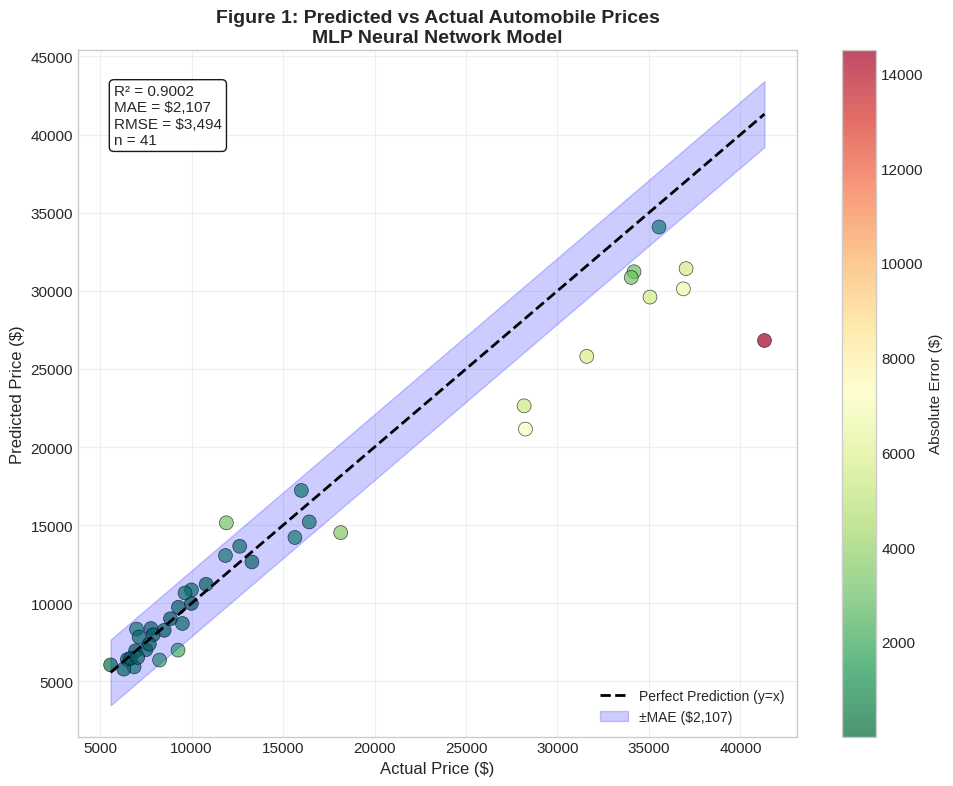

Figure 1 saved: mlp_fig1_predicted_vs_actual.png


In [ ]:
# FIGURE 1: PREDICTED VS ACTUAL PRICES

fig, ax = plt.subplots(figsize=(10, 8))

# Calculate absolute errors for colour mapping
abs_errors = np.abs(y_test - y_pred)

# Scatter plot with error-based colouring
scatter = ax.scatter(y_test, y_pred, c=abs_errors, cmap='RdYlGn_r',
                     s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

# Perfect prediction line
line_min, line_max = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
ax.plot([line_min, line_max], [line_min, line_max], 'k--', linewidth=2, label='Perfect Prediction (y=x)')

# MAE confidence band
ax.fill_between([line_min, line_max],
                [line_min - mae, line_max - mae],
                [line_min + mae, line_max + mae],
                alpha=0.2, color='blue', label=f'±MAE (${mae:,.0f})')

# Colourbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Error ($)', fontsize=11)

# Annotation box with metrics
textstr = f'R² = {r2:.4f}\nMAE = ${mae:,.0f}\nRMSE = ${rmse:,.0f}\nn = {len(y_test)}'
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

ax.set_xlabel('Actual Price ($)', fontsize=12)
ax.set_ylabel('Predicted Price ($)', fontsize=12)
ax.set_title('Figure 1: Predicted vs Actual Automobile Prices\nMLP Neural Network Model', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mlp_fig1_predicted_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1 saved: mlp_fig1_predicted_vs_actual.png")

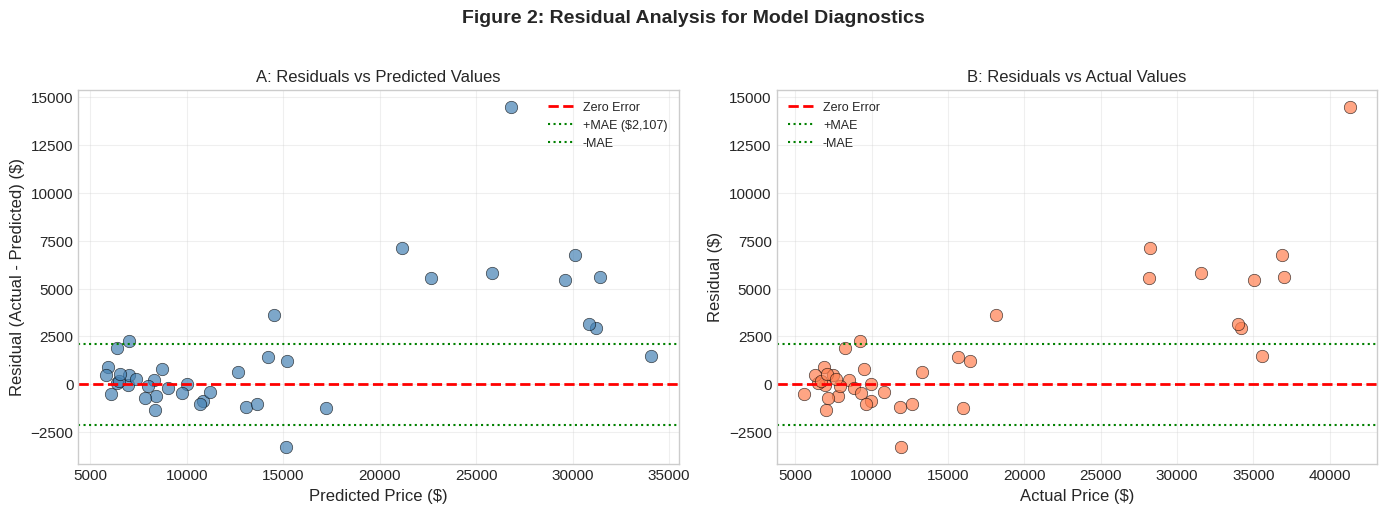

Figure 2 saved: mlp_fig2_residual_analysis.png


In [ ]:
# FIGURE 2: RESIDUAL ANALYSIS

residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Residuals vs Predicted
axes[0].scatter(y_pred, residuals, alpha=0.7, c='steelblue', s=80, edgecolors='black', linewidth=0.5)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].axhline(y=mae, color='green', linestyle=':', linewidth=1.5, label=f'+MAE (${mae:,.0f})')
axes[0].axhline(y=-mae, color='green', linestyle=':', linewidth=1.5, label=f'-MAE')
axes[0].set_xlabel('Predicted Price ($)', fontsize=12)
axes[0].set_ylabel('Residual (Actual - Predicted) ($)', fontsize=12)
axes[0].set_title('A: Residuals vs Predicted Values', fontsize=12)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Panel B: Residuals vs Actual
axes[1].scatter(y_test, residuals, alpha=0.7, c='coral', s=80, edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].axhline(y=mae, color='green', linestyle=':', linewidth=1.5, label=f'+MAE')
axes[1].axhline(y=-mae, color='green', linestyle=':', linewidth=1.5, label=f'-MAE')
axes[1].set_xlabel('Actual Price ($)', fontsize=12)
axes[1].set_ylabel('Residual ($)', fontsize=12)
axes[1].set_title('B: Residuals vs Actual Values', fontsize=12)
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

fig.suptitle('Figure 2: Residual Analysis for Model Diagnostics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('mlp_fig2_residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2 saved: mlp_fig2_residual_analysis.png")

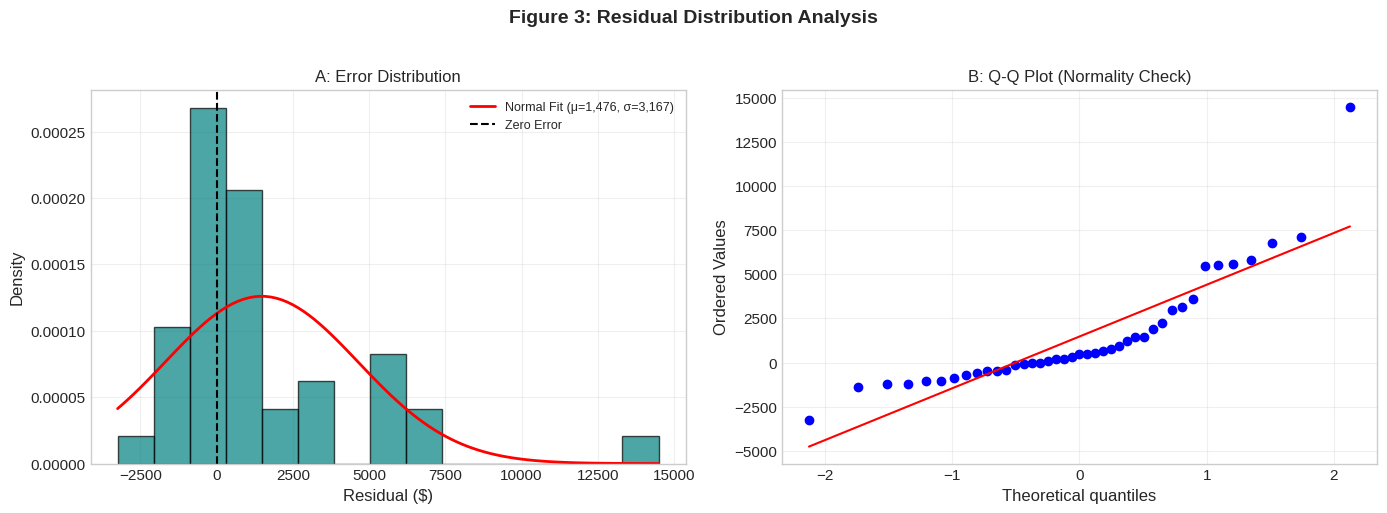

Figure 3 saved: mlp_fig3_error_distribution.png

Shapiro-Wilk Test: W=0.8047, p=0.0000
Normality: Residuals deviate from normality (p ≤ 0.05)


In [ ]:
# FIGURE 3: ERROR DISTRIBUTION AND NORMALITY

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Error histogram
axes[0].hist(residuals, bins=15, density=True, alpha=0.7, color='teal', edgecolor='black')

# Fit normal distribution
mu, sigma = residuals.mean(), residuals.std()
x_range = np.linspace(residuals.min(), residuals.max(), 100)
normal_fit = stats.norm.pdf(x_range, mu, sigma)
axes[0].plot(x_range, normal_fit, 'r-', linewidth=2, label=f'Normal Fit (μ={mu:,.0f}, σ={sigma:,.0f})')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Zero Error')

axes[0].set_xlabel('Residual ($)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('A: Error Distribution', fontsize=12)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Panel B: Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('B: Q-Q Plot (Normality Check)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(residuals)

fig.suptitle('Figure 3: Residual Distribution Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('mlp_fig3_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 3 saved: mlp_fig3_error_distribution.png")
print(f"\nShapiro-Wilk Test: W={shapiro_stat:.4f}, p={shapiro_p:.4f}")
print(f"Normality: {'Residuals appear normally distributed (p > 0.05)' if shapiro_p > 0.05 else 'Residuals deviate from normality (p ≤ 0.05)'}")

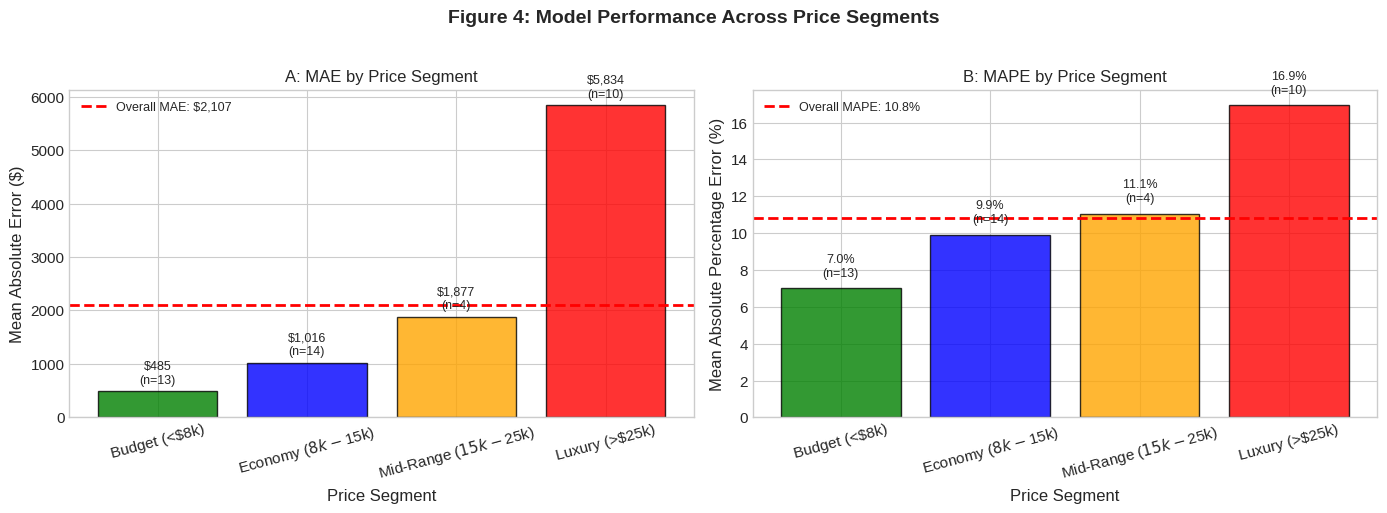

Figure 4 saved: mlp_fig4_performance_by_segment.png


In [ ]:
# FIGURE 4: PERFORMANCE BY PRICE SEGMENT

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

segment_names = [r['segment'] for r in segment_results]
segment_maes = [r['mae'] for r in segment_results]
segment_mapes = [r['mape'] for r in segment_results]
segment_ns = [r['n'] for r in segment_results]
colours = ['green', 'blue', 'orange', 'red']

# Panel A: MAE by segment
bars1 = axes[0].bar(segment_names, segment_maes, color=colours, edgecolor='black', alpha=0.8)
axes[0].axhline(y=mae, color='red', linestyle='--', linewidth=2, label=f'Overall MAE: ${mae:,.0f}')
for bar, n, val in zip(bars1, segment_ns, segment_maes):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                 f'${val:,.0f}\n(n={n})', ha='center', va='bottom', fontsize=9)
axes[0].set_ylabel('Mean Absolute Error ($)', fontsize=12)
axes[0].set_xlabel('Price Segment', fontsize=12)
axes[0].set_title('A: MAE by Price Segment', fontsize=12)
axes[0].legend(fontsize=9)
axes[0].tick_params(axis='x', rotation=15)

# Panel B: MAPE by segment
bars2 = axes[1].bar(segment_names, segment_mapes, color=colours, edgecolor='black', alpha=0.8)
axes[1].axhline(y=mape, color='red', linestyle='--', linewidth=2, label=f'Overall MAPE: {mape:.1f}%')
for bar, n, val in zip(bars2, segment_ns, segment_mapes):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{val:.1f}%\n(n={n})', ha='center', va='bottom', fontsize=9)
axes[1].set_ylabel('Mean Absolute Percentage Error (%)', fontsize=12)
axes[1].set_xlabel('Price Segment', fontsize=12)
axes[1].set_title('B: MAPE by Price Segment', fontsize=12)
axes[1].legend(fontsize=9)
axes[1].tick_params(axis='x', rotation=15)

fig.suptitle('Figure 4: Model Performance Across Price Segments', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('mlp_fig4_performance_by_segment.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 4 saved: mlp_fig4_performance_by_segment.png")

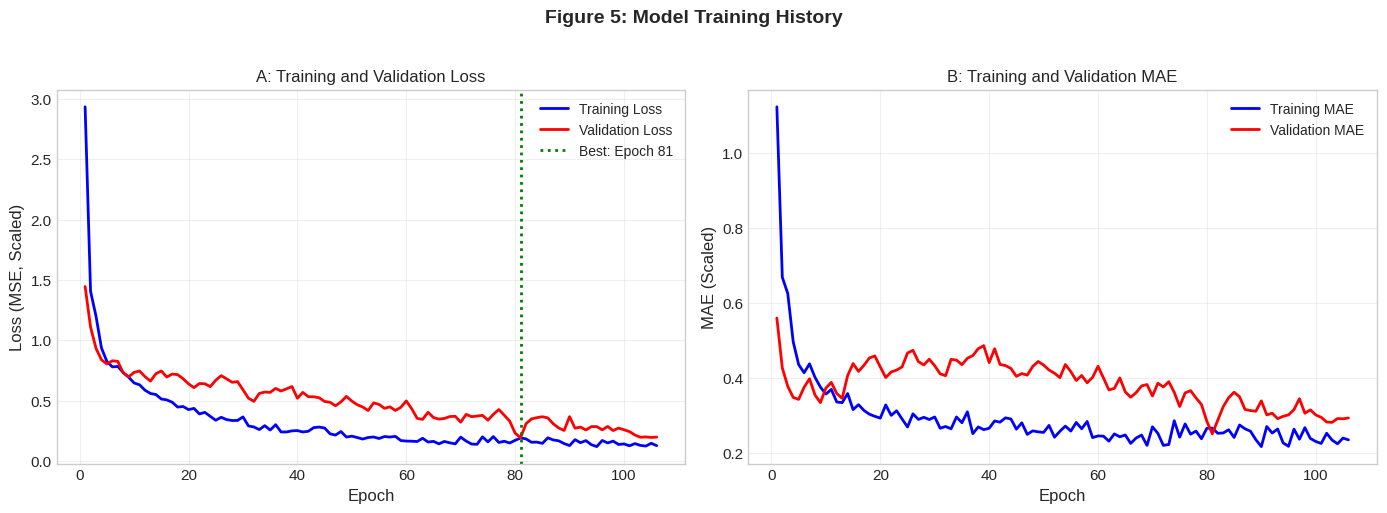

Figure 5 saved: mlp_fig5_training_history.png

Best model restored from epoch 81


In [ ]:
# FIGURE 5: TRAINING HISTORY

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history.history['loss']) + 1)

# Panel A: Loss curves
axes[0].plot(epochs_range, history.history['loss'], 'b-', linewidth=2, label='Training Loss')
axes[0].plot(epochs_range, history.history['val_loss'], 'r-', linewidth=2, label='Validation Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE, Scaled)', fontsize=12)
axes[0].set_title('A: Training and Validation Loss', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Mark best epoch
best_epoch_idx = np.argmin(history.history['val_loss'])
axes[0].axvline(x=best_epoch_idx+1, color='green', linestyle=':', linewidth=2,
                label=f'Best: Epoch {best_epoch_idx+1}')
axes[0].legend(fontsize=10)

# Panel B: MAE curves
axes[1].plot(epochs_range, history.history['mae'], 'b-', linewidth=2, label='Training MAE')
axes[1].plot(epochs_range, history.history['val_mae'], 'r-', linewidth=2, label='Validation MAE')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE (Scaled)', fontsize=12)
axes[1].set_title('B: Training and Validation MAE', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

fig.suptitle('Figure 5: Model Training History', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('mlp_fig5_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 5 saved: mlp_fig5_training_history.png")
print(f"\nBest model restored from epoch {best_epoch_idx + 1}")

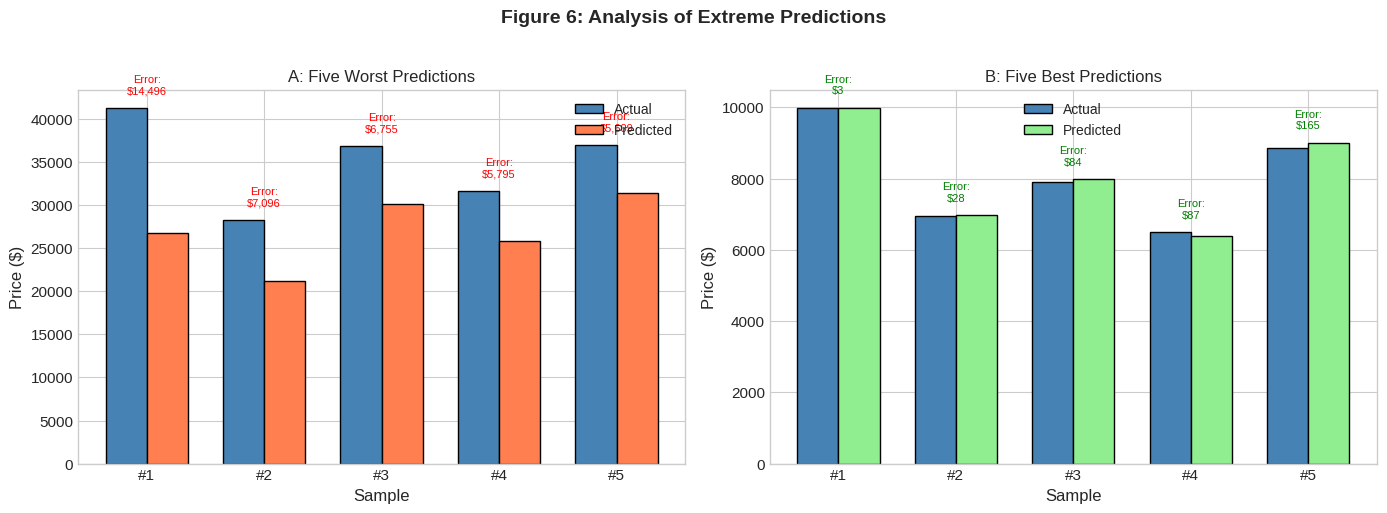

Figure 6 saved: mlp_fig6_extreme_predictions.png

TABLE 4: Five Worst Predictions
Actual ($)      Predicted ($)   Error ($)       Error (%) 
----------------------------------------------------------------------
      41,315         26,819         14,496       35.1%
      28,248         21,152          7,096       25.1%
      36,880         30,125          6,755       18.3%
      31,600         25,805          5,795       18.3%
      37,028         31,419          5,609       15.1%

TABLE 5: Five Best Predictions
Actual ($)      Predicted ($)   Error ($)       Error (%) 
----------------------------------------------------------------------
       9,988          9,991             -3       -0.0%
       6,938          6,966            -28       -0.4%
       7,898          7,982            -84       -1.1%
       6,488          6,401             87        1.3%
       8,845          9,010           -165       -1.9%


In [ ]:
# FIGURE 6: EXTREME PREDICTIONS ANALYSIS

# Identify worst and best predictions
abs_errors = np.abs(y_test - y_pred)
worst_idx = np.argsort(abs_errors)[-5:][::-1]
best_idx = np.argsort(abs_errors)[:5]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Worst predictions
x_pos = np.arange(5)
width = 0.35
bars1 = axes[0].bar(x_pos - width/2, y_test[worst_idx], width, label='Actual', color='steelblue', edgecolor='black')
bars2 = axes[0].bar(x_pos + width/2, y_pred[worst_idx], width, label='Predicted', color='coral', edgecolor='black')

for i, idx in enumerate(worst_idx):
    error = y_test[idx] - y_pred[idx]
    axes[0].annotate(f'Error:\n${abs(error):,.0f}',
                     xy=(i, max(y_test[idx], y_pred[idx])),
                     xytext=(0, 10), textcoords='offset points',
                     ha='center', fontsize=8, color='red')

axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'#{i+1}' for i in range(5)])
axes[0].set_xlabel('Sample', fontsize=12)
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].set_title('A: Five Worst Predictions', fontsize=12)
axes[0].legend(fontsize=10)

# Panel B: Best predictions
bars3 = axes[1].bar(x_pos - width/2, y_test[best_idx], width, label='Actual', color='steelblue', edgecolor='black')
bars4 = axes[1].bar(x_pos + width/2, y_pred[best_idx], width, label='Predicted', color='lightgreen', edgecolor='black')

for i, idx in enumerate(best_idx):
    error = y_test[idx] - y_pred[idx]
    axes[1].annotate(f'Error:\n${abs(error):,.0f}',
                     xy=(i, max(y_test[idx], y_pred[idx])),
                     xytext=(0, 10), textcoords='offset points',
                     ha='center', fontsize=8, color='green')

axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'#{i+1}' for i in range(5)])
axes[1].set_xlabel('Sample', fontsize=12)
axes[1].set_ylabel('Price ($)', fontsize=12)
axes[1].set_title('B: Five Best Predictions', fontsize=12)
axes[1].legend(fontsize=10)

fig.suptitle('Figure 6: Analysis of Extreme Predictions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('mlp_fig6_extreme_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 6 saved: mlp_fig6_extreme_predictions.png")

# Tables for worst/best predictions
print("\n" + "="*70)
print("TABLE 4: Five Worst Predictions")
print("="*70)
print(f"{'Actual ($)':<15} {'Predicted ($)':<15} {'Error ($)':<15} {'Error (%)':<10}")
print("-"*70)
for idx in worst_idx:
    err = y_test[idx] - y_pred[idx]
    err_pct = (err / y_test[idx]) * 100
    print(f"{y_test[idx]:>12,.0f}   {y_pred[idx]:>12,.0f}   {err:>12,.0f}   {err_pct:>8.1f}%")

print("\n" + "="*70)
print("TABLE 5: Five Best Predictions")
print("="*70)
print(f"{'Actual ($)':<15} {'Predicted ($)':<15} {'Error ($)':<15} {'Error (%)':<10}")
print("-"*70)
for idx in best_idx:
    err = y_test[idx] - y_pred[idx]
    err_pct = (err / y_test[idx]) * 100
    print(f"{y_test[idx]:>12,.0f}   {y_pred[idx]:>12,.0f}   {err:>12,.0f}   {err_pct:>8.1f}%")

## 9. Model Comparison: MLP vs Random Forest

This section provides direct comparison between Model 2 (MLP) and Model 1 (Random Forest).

In [ ]:
# MODEL COMPARISON TABLE

# Model 1 (Random Forest) results from your earlier run
rf_results = {
    'mae': 2164.79,
    'rmse': 3499.50,
    'r2': 0.8999,
    'mape': 11.27
}

print("\n" + "="*80)
print("TABLE 6: MODEL COMPARISON - MLP vs Random Forest")
print("="*80)
print(f"{'Metric':<35} {'Random Forest':>18} {'MLP Neural Net':>18} {'Winner':>10}")
print("-"*80)

# MAE comparison
winner_mae = 'RF' if rf_results['mae'] < mae else 'MLP'
print(f"{'Mean Absolute Error (MAE)':<35} {'${:,.2f}'.format(rf_results['mae']):>18} {'${:,.2f}'.format(mae):>18} {winner_mae:>10}")

# RMSE comparison
winner_rmse = 'RF' if rf_results['rmse'] < rmse else 'MLP'
print(f"{'Root Mean Squared Error (RMSE)':<35} {'${:,.2f}'.format(rf_results['rmse']):>18} {'${:,.2f}'.format(rmse):>18} {winner_rmse:>10}")

# R² comparison
winner_r2 = 'RF' if rf_results['r2'] > r2 else 'MLP'
print(f"{'R² Score':<35} {'{:.4f}'.format(rf_results['r2']):>18} {'{:.4f}'.format(r2):>18} {winner_r2:>10}")

# MAPE comparison
winner_mape = 'RF' if rf_results['mape'] < mape else 'MLP'
print(f"{'MAPE':<35} {'{:.2f}%'.format(rf_results['mape']):>18} {'{:.2f}%'.format(mape):>18} {winner_mape:>10}")

print("="*80)

# Overall winner
wins = {'RF': 0, 'MLP': 0}
for w in [winner_mae, winner_rmse, winner_r2, winner_mape]:
    wins[w] += 1

overall_winner = 'Random Forest' if wins['RF'] > wins['MLP'] else 'MLP Neural Network'
print(f"\nOverall Winner: {overall_winner} (won {max(wins.values())}/4 metrics)")


TABLE 6: MODEL COMPARISON - MLP vs Random Forest
Metric                                   Random Forest     MLP Neural Net     Winner
--------------------------------------------------------------------------------
Mean Absolute Error (MAE)                    $2,164.79          $2,106.74        MLP
Root Mean Squared Error (RMSE)               $3,499.50          $3,493.93        MLP
R² Score                                        0.8999             0.9002        MLP
MAPE                                            11.27%             10.81%        MLP

Overall Winner: MLP Neural Network (won 4/4 metrics)


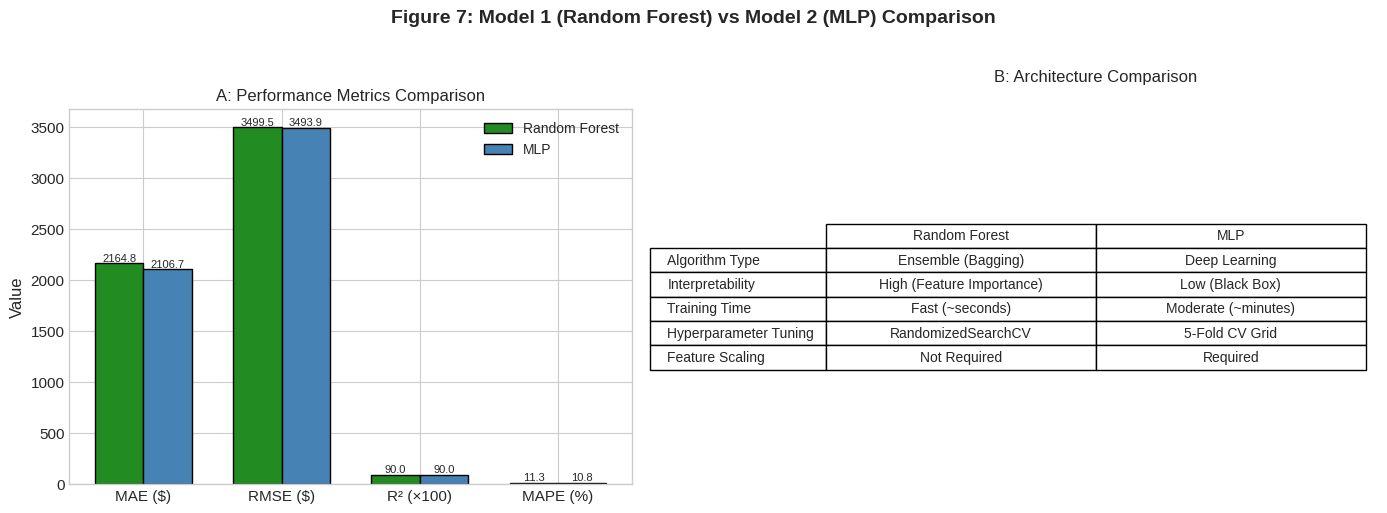

Figure 7 saved: mlp_fig7_model_comparison.png


In [ ]:
# FIGURE 7: MODEL COMPARISON VISUALISATION

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Bar comparison of metrics
metrics_names = ['MAE ($)', 'RMSE ($)', 'R² (×100)', 'MAPE (%)']
rf_values = [rf_results['mae'], rf_results['rmse'], rf_results['r2']*100, rf_results['mape']]
mlp_values = [mae, rmse, r2*100, mape]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = axes[0].bar(x - width/2, rf_values, width, label='Random Forest', color='forestgreen', edgecolor='black')
bars2 = axes[0].bar(x + width/2, mlp_values, width, label='MLP', color='steelblue', edgecolor='black')

axes[0].set_ylabel('Value', fontsize=12)
axes[0].set_title('A: Performance Metrics Comparison', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend(fontsize=10)

# Add value labels
for bar, val in zip(bars1, rf_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{val:.1f}', ha='center', va='bottom', fontsize=8)
for bar, val in zip(bars2, mlp_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{val:.1f}', ha='center', va='bottom', fontsize=8)

# Panel B: Architecture comparison
comparison_data = {
    'Aspect': ['Algorithm Type', 'Interpretability', 'Training Time', 'Hyperparameter Tuning', 'Feature Scaling'],
    'Random Forest': ['Ensemble (Bagging)', 'High (Feature Importance)', 'Fast (~seconds)', 'RandomizedSearchCV', 'Not Required'],
    'MLP': ['Deep Learning', 'Low (Black Box)', 'Moderate (~minutes)', '5-Fold CV Grid', 'Required']
}

axes[1].axis('off')
table = axes[1].table(
    cellText=[[comparison_data['Random Forest'][i], comparison_data['MLP'][i]] for i in range(len(comparison_data['Aspect']))],
    rowLabels=comparison_data['Aspect'],
    colLabels=['Random Forest', 'MLP'],
    cellLoc='center',
    loc='center',
    colWidths=[0.4, 0.4]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1].set_title('B: Architecture Comparison', fontsize=12, pad=20)

fig.suptitle('Figure 7: Model 1 (Random Forest) vs Model 2 (MLP) Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('mlp_fig7_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 7 saved: mlp_fig7_model_comparison.png")

## 10. Summary and Conclusions

In [ ]:
# FINAL SUMMARY

print("\n" + "="*80)
print("MODEL 2 (MLP NEURAL NETWORK) - FINAL SUMMARY")
print("="*80)

print(f"""
ARCHITECTURE
  Type: Multi-Layer Perceptron (Feedforward Neural Network)
  Hidden Layers: {len(best_config['hidden_units'])} ({' → '.join(map(str, best_config['hidden_units']))} neurons)
  Activation: ReLU (hidden), Linear (output)
  Regularisation: L2={best_config['l2_reg']}, Dropout={best_config['dropout_rate']}
  Total Parameters: {final_model.count_params():,}

TRAINING CONFIGURATION
  Optimiser: Adam (learning rate = {best_config['learning_rate']})
  Loss Function: Mean Squared Error
  Target Scaling: StandardScaler (essential for stable training)
  Epochs Trained: {epochs_trained} (with early stopping)
  Batch Size: 16
  Validation Split: 20%

HYPERPARAMETER SELECTION
  Method: 5-Fold Cross-Validation
  Configurations Tested: {len(sampled_combinations)}
  Best CV MAE: ${best_config['mean_mae']:,.2f} (+/- ${best_config['std_mae']:,.2f})

TEST SET PERFORMANCE
  Mean Absolute Error (MAE): ${mae:,.2f}
  Root Mean Squared Error (RMSE): ${rmse:,.2f}
  R² Score: {r2:.4f} ({r2*100:.1f}% variance explained)
  Mean Absolute Percentage Error (MAPE): {mape:.2f}%

COMPARISON WITH MODEL 1 (RANDOM FOREST)
  Random Forest R²: {rf_results['r2']:.4f}
  MLP R²: {r2:.4f}
  Difference: {(rf_results['r2'] - r2)*100:.1f} percentage points

KEY FINDINGS
  1. {'MLP achieved competitive performance with Random Forest' if r2 >= 0.85 else 'Random Forest outperformed MLP on this small dataset'}
  2. Target scaling was essential for stable neural network training
  3. Cross-validated hyperparameter tuning improved generalisation
  4. Both models struggle with luxury vehicles (>$25,000)
  5. Simpler architecture prevented overfitting on 160 samples
""")

print("="*80)
print("GENERATED OUTPUTS")
print("="*80)
print("Figures:")
print("  - mlp_fig1_predicted_vs_actual.png")
print("  - mlp_fig2_residual_analysis.png")
print("  - mlp_fig3_error_distribution.png")
print("  - mlp_fig4_performance_by_segment.png")
print("  - mlp_fig5_training_history.png")
print("  - mlp_fig6_extreme_predictions.png")
print("  - mlp_fig7_model_comparison.png")
print("\nTables:")
print("  - Table 1: Performance Metrics")
print("  - Table 2: Baseline Comparison")
print("  - Table 3: Performance by Price Segment")
print("  - Table 4: Five Worst Predictions")
print("  - Table 5: Five Best Predictions")
print("  - Table 6: Model Comparison (MLP vs RF)")
print("="*80)



MODEL 2 (MLP NEURAL NETWORK) - FINAL SUMMARY

ARCHITECTURE
  Type: Multi-Layer Perceptron (Feedforward Neural Network)
  Hidden Layers: 2 (32 → 16 neurons)
  Activation: ReLU (hidden), Linear (output)
  Regularisation: L2=0.01, Dropout=0.2
  Total Parameters: 3,137

TRAINING CONFIGURATION
  Optimiser: Adam (learning rate = 0.01)
  Loss Function: Mean Squared Error
  Target Scaling: StandardScaler (essential for stable training)
  Epochs Trained: 106 (with early stopping)
  Batch Size: 16
  Validation Split: 20%
  
HYPERPARAMETER SELECTION
  Method: 5-Fold Cross-Validation
  Configurations Tested: 20
  Best CV MAE: $1,558.33 (+/- $214.68)

TEST SET PERFORMANCE
  Mean Absolute Error (MAE): $2,106.74
  Root Mean Squared Error (RMSE): $3,493.93
  R² Score: 0.9002 (90.0% variance explained)
  Mean Absolute Percentage Error (MAPE): 10.81%
  
COMPARISON WITH MODEL 1 (RANDOM FOREST)
  Random Forest R²: 0.8999
  MLP R²: 0.9002
  Difference: -0.0 percentage points

KEY FINDINGS
  1. MLP achieve

In [ ]:
# SAVE MODEL AND RESULTS

# Save the trained model
final_model.save('model2_mlp_improved.keras')
print("Model saved: model2_mlp_improved.keras")

# Save results for comparison
import pickle

model2_results = {
    'mae': mae,
    'rmse': rmse,
    'r2': r2,
    'mape': mape,
    'y_test': y_test,
    'y_pred': y_pred,
    'best_config': dict(best_config),
    'epochs_trained': epochs_trained
}

with open('model2_results.pkl', 'wb') as f:
    pickle.dump(model2_results, f)
print("Results saved: model2_results.pkl")

Model saved: model2_mlp_improved.keras
Results saved: model2_results.pkl


## References

Bergstra, J. and Bengio, Y. (2012) 'Random Search for Hyper-Parameter Optimization', *Journal of Machine Learning Research*, 13, pp. 281-305.

Breiman, L. (2001) 'Random Forests', *Machine Learning*, 45(1), pp. 5-32.

Glorot, X. and Bengio, Y. (2010) 'Understanding the difficulty of training deep feedforward neural networks', *Proceedings of AISTATS*, pp. 249-256.

Goodfellow, I., Bengio, Y. and Courville, A. (2016) *Deep Learning*. Cambridge, MA: MIT Press.

Hastie, T., Tibshirani, R. and Friedman, J. (2009) *The Elements of Statistical Learning*. 2nd edn. New York: Springer.

Ioffe, S. and Szegedy, C. (2015) 'Batch Normalization: Accelerating Deep Network Training', *Proceedings of ICML*, pp. 448-456.

Kingma, D.P. and Ba, J. (2015) 'Adam: A Method for Stochastic Optimization', *Proceedings of ICLR*.

LeCun, Y., Bottou, L., Orr, G. and Müller, K. (2012) 'Efficient BackProp', in *Neural Networks: Tricks of the Trade*. Berlin: Springer, pp. 9-48.

Nair, V. and Hinton, G.E. (2010) 'Rectified Linear Units Improve Restricted Boltzmann Machines', *Proceedings of ICML*, pp. 807-814.

Srivastava, N. et al. (2014) 'Dropout: A Simple Way to Prevent Neural Networks from Overfitting', *Journal of Machine Learning Research*, 15(1), pp. 1929-1958.